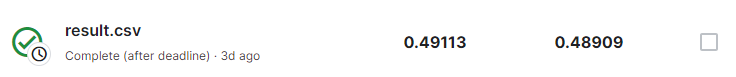

In [2]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetB0

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

### 이미지 전처리

In [10]:
IMAGE_SIZE = (224, 224)
IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    
    # 이미지 크기 확인
    height, width, _ = image.shape
    
    # 이미지 크기가 (2048, 1365)일 경우 회전하여 크기 변경
    if height == 2048 and width == 1365:
        image = np.rot90(image)

    # 이미지를 224, 224로 줄이기
    image = cv2.resize(image, IMAGE_SIZE)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

images = train_data["image_id"].apply(load_image)



In [4]:
images = np.stack(images)
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [5]:
np.where(labels[:, 1] == 1)[0]

array([   1,    6,   25,   36,   62,   74,   95,  104,  113,  122,  128,
        170,  180,  231,  237,  245,  306,  336,  338,  363,  391,  395,
        399,  418,  428,  436,  480,  484,  493,  517,  535,  543,  563,
        602,  629,  645,  682,  702,  732,  754,  762,  857,  886,  905,
        936,  949, 1013, 1018, 1028, 1035, 1046, 1050, 1119, 1129, 1134,
       1161, 1173, 1197, 1216, 1234, 1236, 1264, 1270, 1280, 1310, 1358,
       1369, 1390, 1433, 1454, 1468, 1494, 1514, 1526, 1531, 1536, 1554,
       1558, 1573, 1577, 1609, 1618, 1641, 1648, 1662, 1664, 1708, 1779,
       1780, 1784, 1815], dtype=int64)

In [77]:
y_categorical = np.argmax(labels, axis=1)
k = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True)

for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
    
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   fill_mode='nearest',
                                   )

    val_datagen = ImageDataGenerator(rescale=1./255)

    BATCH_SIZE = 5
    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE)

    efmodel = EfficientNetB0(include_top=False, weights='imagenet', input_shape= (IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
    efmodel.trainable = False

    model = Sequential()
    model.add(efmodel)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005), metrics=['accuracy'])

    modelpath = f'./train{i}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)
    history = model.fit(train_generator, epochs=10000, verbose=1, callbacks=[early_stopping_callback, checkpointer], validation_data=val_generator)



TypeError: __init__() got an unexpected keyword argument 'resize'